# Fast Options Pricing

This notebook investigates **fast option pricing** using **machine learning surrogates** trained on data generated from the **Heston stochastic volatility model**.  
Monte Carlo simulations provide accurate but computationally expensive reference prices, while neural network or regression-based surrogate models aim to approximate these results at a fraction of the computational cost.

The workflow includes:
1. Generating synthetic option data via `HestonMonteCarloPricer` and `DataGenerator`.
2. Training surrogate models to learn the mapping from model parameters and option inputs to prices.
3. Evaluating prediction accuracy and feature importance.
4. Demonstrating how such surrogates can enable real-time option valuation and calibration.

This approach combines the **rigour of stochastic pricing** with the **speed of data-driven approximation**, offering a scalable framework for efficient derivative pricing.


# Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent / "src"))
from heston_mc import HestonMonteCarloPricer, DataGenerator, SurrogateModel


# Generate Data

In [4]:
pricer = HestonMonteCarloPricer(n_paths=5000, n_steps=100)
gen = DataGenerator(pricer)
data = gen.generate(1000)

In [5]:
X = data[["S", "K", "T", "r", "kappa", "theta", "sigma_v", "rho", "v0"]]
y = data["price"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


# Train the Model

In [7]:
surrogate = SurrogateModel()
surrogate.train(X_train, y_train)

# Surrogate Model Evaluation

The trained surrogate model is evaluated against Monte Carlo–simulated option prices using **Root Mean Squared Error (RMSE)** and **R²** metrics.  
A scatter plot compares the predicted prices with the true simulated values, with the red dashed line indicating perfect agreement.

A close alignment of points along this diagonal confirms that the surrogate accurately reproduces the Heston Monte Carlo results, validating its effectiveness as a **fast and reliable pricing approximation**.


RMSE: 1.3905   R²: 0.9948


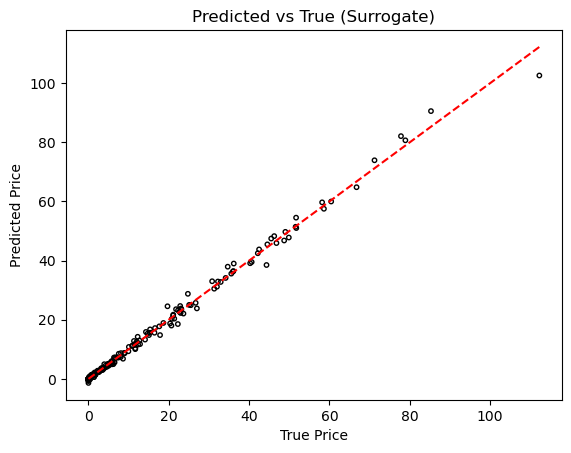

In [8]:
rmse, r2, y_pred = surrogate.evaluate(X_test, y_test)
print(f"RMSE: {rmse:.4f}   R²: {r2:.4f}")

plt.figure()
plt.scatter(y_test, y_pred, s=10, edgecolors="k", facecolors="none")
lims = [0, max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--")
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs True (Surrogate)")
plt.show()

# Speed Benchmark: Monte Carlo vs Surrogate

To assess computational efficiency, both the **Monte Carlo pricer** and the **machine learning surrogate** are timed on the same option input.  
The benchmark reports average runtimes and the resulting **speedup factor**.

The surrogate model achieves a substantial performance gain while maintaining close agreement with the Monte Carlo reference.  
This highlights its suitability for **real-time pricing**, **risk management**, and **model calibration** tasks where rapid evaluations are essential.


In [9]:
params = {"S0": 120, "K": 100, "T": 1.0, "r": 0.02,
          "kappa": 2.0, "theta": 0.06, "sigma_v": 0.6,
          "rho": -0.5, "v0": 0.04}

X_sample = pd.DataFrame([{
    "S": 120, "K": 100, "T": 1.0, "r": 0.02,
    "kappa": 2.0, "theta": 0.06, "sigma_v": 0.6, "rho": -0.5, "v0": 0.04
}])

mc_time, ml_time, speedup = surrogate.benchmark(X_sample, pricer, params)
print(f"\nMonte Carlo avg: {mc_time*1000:.3f} ms | Surrogate avg: {ml_time*1000:.3f} ms | Speedup: {speedup:.1f}x")



Monte Carlo avg: 41.373 ms | Surrogate avg: 0.854 ms | Speedup: 48.5x


# Sensitivity Analysis — Volatility of Volatility (σᵥ)

This plot compares **Monte Carlo** and **surrogate model** prices as a function of the **volatility of volatility (σᵥ)** parameter in the Heston model, with all other parameters held fixed.

The close overlap between the two curves demonstrates that the machine learning surrogate accurately captures the sensitivity of the option price to σᵥ, preserving the key nonlinear characteristics of the stochastic volatility dynamics while offering dramatically faster computation.


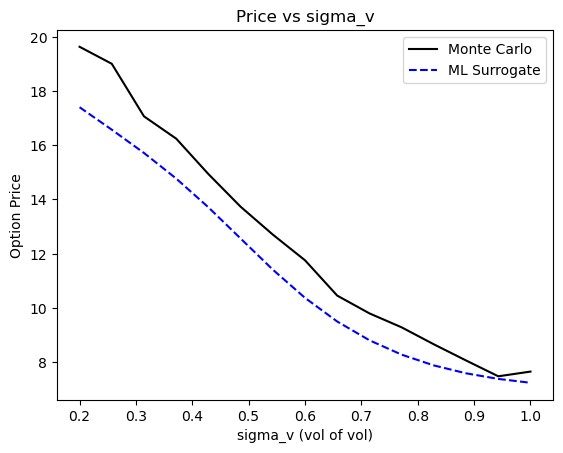

In [10]:
grid = np.linspace(0.2, 1.0, 15)
true_prices = [pricer.price(120, 100, 1.0, 0.02, 2.0, 0.06, s, -0.5, 0.04) for s in grid]
pred_prices = surrogate.predict(pd.DataFrame({
    "S": [120]*len(grid), "K": [100]*len(grid), "T": [1.0]*len(grid),
    "r": [0.02]*len(grid), "kappa": [2.0]*len(grid), "theta": [0.06]*len(grid),
    "sigma_v": grid, "rho": [-0.5]*len(grid), "v0": [0.04]*len(grid)
}))

plt.figure()
plt.plot(grid, true_prices, "k-", label="Monte Carlo")
plt.plot(grid, pred_prices, "b--", label="ML Surrogate")
plt.xlabel("sigma_v (vol of vol)")
plt.ylabel("Option Price")
plt.title("Price vs sigma_v")
plt.legend()
plt.show()

# Surrogate Error Heat Map

The heat map visualises the **average absolute prediction error** of the surrogate model across different regions of the option parameter space, defined by **moneyness (S/K)** and **time to maturity (T)**.

Areas with brighter colours indicate regions where the surrogate deviates more from the Monte Carlo reference.  
This diagnostic helps identify where the model performs best—typically around at-the-money, moderate-maturity options—and where further training data or model refinement may be needed to improve accuracy.


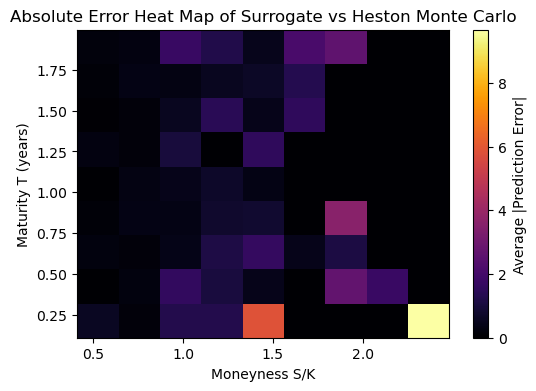

In [11]:

# Compute absolute error
moneyness = X_test["S"] / X_test["K"]
y_pred = surrogate.predict(X_test)
abs_error = np.abs(y_pred - y_test)

# Define 2D grid bins
moneyness_bins = np.linspace(moneyness.min(), moneyness.max(), 10)
maturity_bins = np.linspace(X_test["T"].min(), X_test["T"].max(), 10)

# Bin average absolute errors
heatmap, xedges, yedges = np.histogram2d(
    moneyness, X_test["T"], bins=[moneyness_bins, maturity_bins],
    weights=abs_error
)
counts, _, _ = np.histogram2d(moneyness, X_test["T"], bins=[moneyness_bins, maturity_bins])
avg_error = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts > 0)

# Plot heatmap
plt.figure(figsize=(6, 4))
Xgrid, Ygrid = np.meshgrid(xedges, yedges)
pcm = plt.pcolormesh(Xgrid, Ygrid, avg_error.T, cmap="inferno")
plt.colorbar(pcm, label="Average |Prediction Error|")
plt.xlabel("Moneyness S/K")
plt.ylabel("Maturity T (years)")
plt.title("Absolute Error Heat Map of Surrogate vs Heston Monte Carlo")
plt.show()


# Assesing Feature Importance

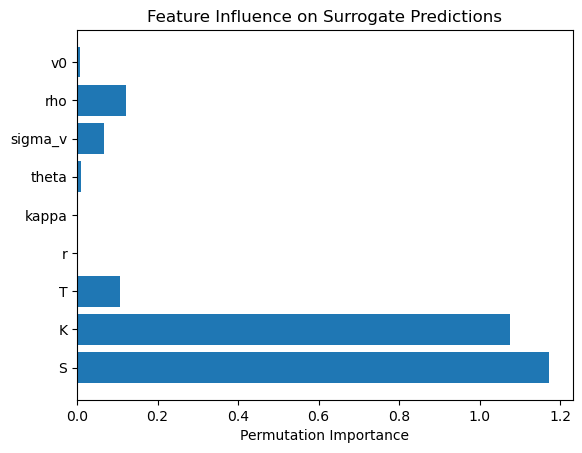

In [12]:
pi = permutation_importance(surrogate.model, X_test, y_test, n_repeats=8, random_state=0)
plt.barh(X_test.columns, pi.importances_mean)
plt.xlabel("Permutation Importance")
plt.title("Feature Influence on Surrogate Predictions")
plt.show()


# Greeks Estimation — Delta via Finite Differences

The **Delta** (*δ*) represents the sensitivity of the option price to small changes in the underlying asset price, mathematically defined as  

$$
\delta = \frac{\partial V}{\partial S}
$$

Using the surrogate model, *δ* is approximated numerically with a **central finite difference**:

$$
\delta \approx \frac{V(S + \varepsilon S) - V(S - \varepsilon S)}{2 \varepsilon S}
$$

where $ \varepsilon = 10^{-3} $ is a small perturbation fraction of the spot price.  

This demonstrates that the trained surrogate provides smooth, differentiable estimates of option sensitivities, enabling efficient computation of **Greeks** without repeated Monte Carlo simulations.


In [13]:
eps = 1e-3
base = X_sample.copy()
up = base.copy(); up["S"] += eps*base["S"]
down = base.copy(); down["S"] -= eps*base["S"]

price_up = surrogate.predict(up)[0]
price_down = surrogate.predict(down)[0]
delta = (price_up - price_down) / (2*eps*base["S"][0])
print("Approximate Delta:", delta)


Approximate Delta: 0.6632440010224524
